<a href="https://colab.research.google.com/github/tvpian/A-Star-Path-Planning/blob/main/GenAI%3A%20Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_swiss_roll
import torch.nn as nn

In [2]:
print(make_swiss_roll.__doc__)

Generate a swiss roll dataset.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, default=100
        The number of sample points on the Swiss Roll.

    noise : float, default=0.0
        The standard deviation of the gaussian noise.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    hole : bool, default=False
        If True generates the swiss roll with hole dataset.

    Returns
    -------
    X : ndarray of shape (n_samples, 3)
        The points.

    t : ndarray of shape (n_samples,)
        The univariate position of the sample according to the main dimension
        of the points in the manifold.

    Notes
    -----
    The algorithm is from Marsland [1].

    References
    ----------
    .. [1] S. Marsland,

In [3]:
n_samples = 1000
data, _ = make_swiss_roll(1000)

In [4]:
data.shape

(1000, 3)

In [5]:
data = data[:,[2,0]]/10

In [6]:
data = data * np.array([1,-2])

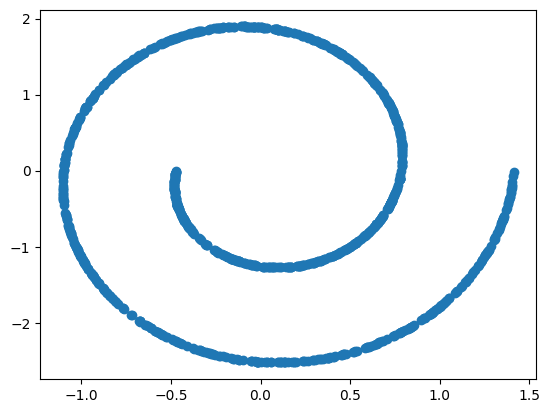

In [7]:
plt.scatter(data[:,0:1],data[:,1:])

# Forward Process

In [8]:
def forward_process(data, T, betas):
  for t in range(T):
     beta_t = betas[t]
     mu = data * torch.sqrt(1 -  beta_t)
     std = torch.sqrt(beta_t)
     data =  mu + torch.randn_like(data) * std

  return data


In [9]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
xT = forward_process(torch.from_numpy(data), T, betas)

In [10]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0047, -0.0248], dtype=torch.float64)
tensor([0.9877, 0.9890], dtype=torch.float64)


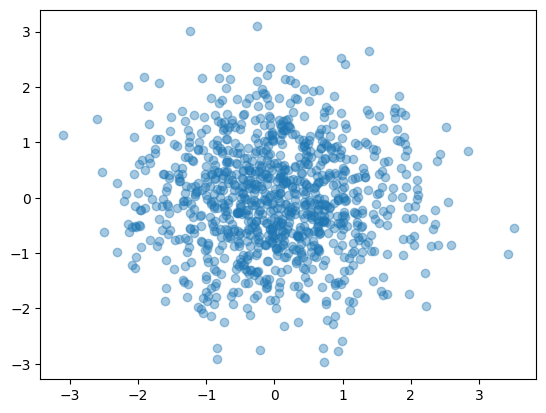

In [11]:
plt.scatter(xT[:,0].data.numpy(), xT[:,1].data.numpy(), alpha = 0.4)
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.show()




# Implement Forward Process without Control Flows

In [12]:
class DiffusionModel():

  def __init__(self, T):
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1 - self.betas
    self.alpha_bar = torch.cumprod(self.alphas, dim = 0)

  def sample_batch(self, batch_size, device = 'cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:,[2,0]]/10
    data = data * np.array([1,-1])
    return torch.from_numpy(data).to(device)

  def forward_process(self, x0, t):
    """
    :param t: Number of diffusion steps
    """
    assert t > 0 and t <= T, 't > 0 and t <= T'
    t = t - 1
    mu = x0 * torch.sqrt(self.alpha_bar[t])
    std = torch.sqrt(1 - self.alpha_bar[t])
    epsilon = torch.randn_like(x0)
    data = mu + std * epsilon
    return data


In [13]:
T = 40
t = 22
batch_size = 1000
model = DiffusionModel(T)
data = model.sample_batch(batch_size)
xT = model.forward_process(data, t)

In [14]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0222, -0.2303], dtype=torch.float64)
tensor([0.7175, 0.6713], dtype=torch.float64)


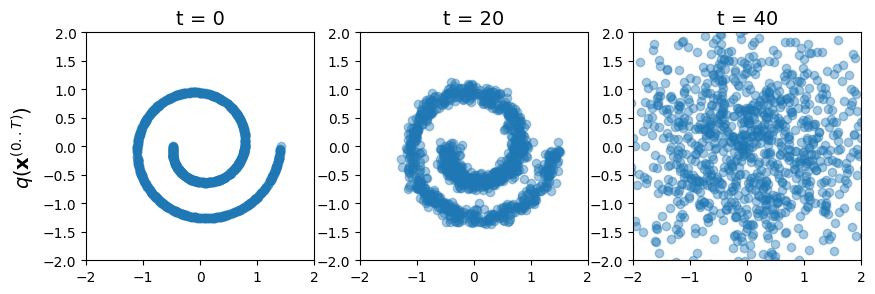

<Figure size 640x480 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(10,3))
fontsize = 14
t = [0, 20, 40]
sample = [data, model.forward_process(data, t[1]), model.forward_process(data, t[2])]
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.scatter(sample[i][:,0].data.numpy(), sample[i][:,1].data.numpy(), alpha = 0.4)
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.gca().set_aspect('equal')
  if i == 0:
    plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize = fontsize)
  plt.title('t = {}'.format(t[i]), fontsize = fontsize)

plt.show()
plt.savefig('forward process')

# Implement Reverse Process - Amortization Approach

In [77]:
def sample_batch(batch_size, device = 'cpu'):
  data, _ = make_swiss_roll(batch_size)
  data = data[:,[2,0]]/10
  data = data * np.array([1,-1])
  return torch.from_numpy(data).to(device)

In [78]:
class MLP(nn.Module):
  def __init__(self, N = 40, data_dim = 2, hidden_dim = 64):
    super(MLP, self).__init__()

    self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                      nn.ReLU(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.ReLU(),)

    self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, data_dim * 2),)# 4 dimension because mean and variance of two dimension
                                       for t in range(N)])


  def forward(self, x, t):

    h = self.network_head(x) # [batch_size, hidden_dim]
    tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
    mu, h = torch.chunk(tmp, 2, dim = 1)
    var = torch.exp(h) # Ensuring that the standar deviation is greater than 0
    std = torch.sqrt(var)

    return mu, std


In [79]:
# model = MLP()
# t = 5
# x = torch.randn((64, 2))
# mu, std = model(x,t)
# mu.shape, std.shape

In [155]:
class DiffusionModel():

  def __init__(self, T, model: nn.Module, dim = 2):
    self.T = T
    self.model = model
    self.dim = dim
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1 - self.betas
    self.alpha_bar = torch.cumprod(self.alphas, dim = 0)


  def forward_process(self, x0, t):
    """
    :param t: Number of diffusion steps
    """
    assert t > 0 and t <= self.T, f't > 0 and t <= {self.T}'
    t = t - 1
    mu = x0 * torch.sqrt(self.alpha_bar[t])
    std = torch.sqrt(1 - self.alpha_bar[t])
    epsilon = torch.randn_like(x0)
    data = mu + std * epsilon
    return data

  def reverse_process(self, xt, t):
    """
    :param t: Number of diffusion steps
    """
    assert t > 0 and t <= self.T, f't > 0 and t <= {self.T}'

    t = t - 1

    mu, std = self.model(xt, t) # Model is made to predict the mean mu and std

    epsilon = torch.randn_like(xt)
    data = mu + std * epsilon # Even the reverse process is Gaussian
                              # Objective is to find the mu and std at every
                              # timestep again and apply it one the noisy distribution at that timestep
    return data

  def sample(self, batch_size):
    noise = torch.randn((batch_size, self.dim))
    x = noise
    samples = []
    for i in range(self.T, 0, -1):
      if i != 1:
        x = self.reverse_process(x,i)
      else:
        pass
      samples.append(x)
    samples.reverse()
    return samples


In [156]:
mlp_model = MLP()
mlp_model = torch.load("/content/model_paper1")

In [157]:
data_dim = 2
x0 = sample_batch(3000)
dmodel = DiffusionModel(40, mlp_model, data_dim)
xT = dmodel.forward_process(data, 20)

In [158]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0228, -0.2351], dtype=torch.float64)
tensor([0.6988, 0.6616], dtype=torch.float64)


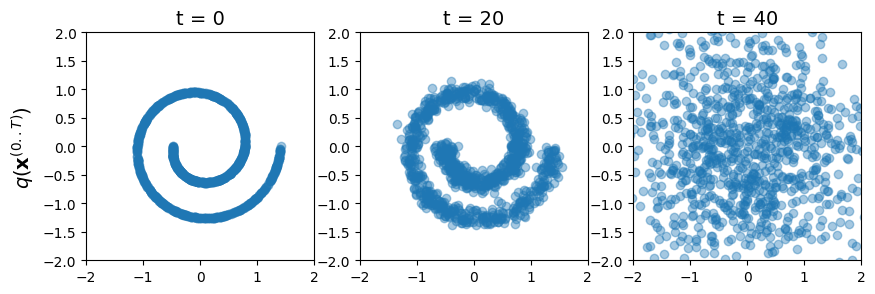

<Figure size 640x480 with 0 Axes>

In [159]:
fig = plt.figure(figsize=(10,3))
fontsize = 14
t = [0, 20, 40]
sample = [data, dmodel.forward_process(data, t[1]), dmodel.forward_process(data, t[2])]
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.scatter(sample[i][:,0].data.numpy(), sample[i][:,1].data.numpy(), alpha = 0.4)
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.gca().set_aspect('equal')
  if i == 0:
    plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize = fontsize)
  plt.title('t = {}'.format(t[i]), fontsize = fontsize)

plt.show()
plt.savefig('forward process')

In [162]:
samples = dmodel.sample(1000)

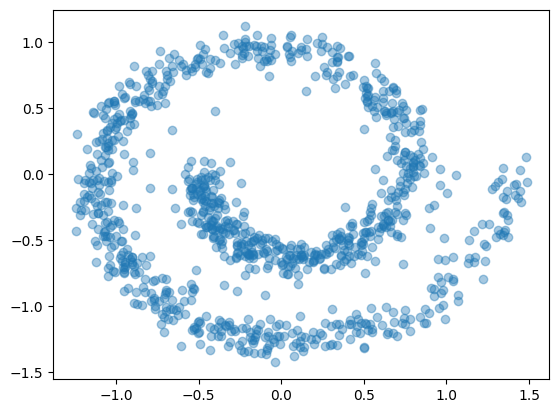

In [171]:
t = 20
plt.scatter(samples[t-1][:,0].data.numpy(), samples[t-1][:,1].data.numpy(), alpha = 0.4)
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.show()

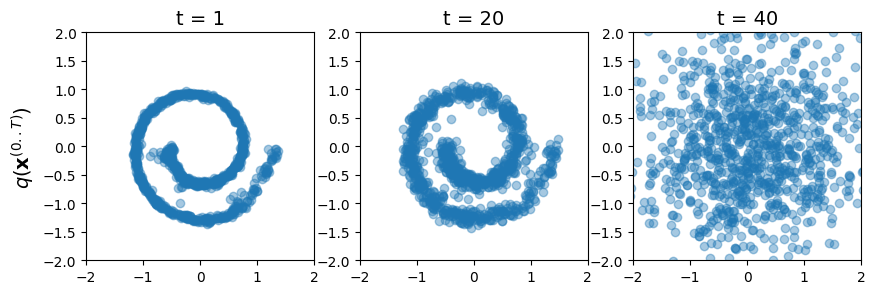

<Figure size 640x480 with 0 Axes>

In [173]:
fig = plt.figure(figsize=(10,3))
fontsize = 14
t = [1, 20, 40]
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.scatter(samples[t[i]-1][:,0].data.numpy(), samples[t[i]-1][:,1].data.numpy(), alpha = 0.4)
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.gca().set_aspect('equal')
  if i == 0:
    plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize = fontsize)
  plt.title('t = {}'.format(t[i]), fontsize = fontsize)
plt.show()
plt.savefig('reverse process')